In [1]:
from datasets import load_dataset
from huggingface_hub import login
import os
from dotenv import load_dotenv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

load_dotenv()

c:\Users\alex\Desktop\SuperRes\sr_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
login(token=os.getenv("HF_TOKEN"))
ds = load_dataset("shivamsark/div2k")
type(ds)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


datasets.dataset_dict.DatasetDict

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 320
    })
})

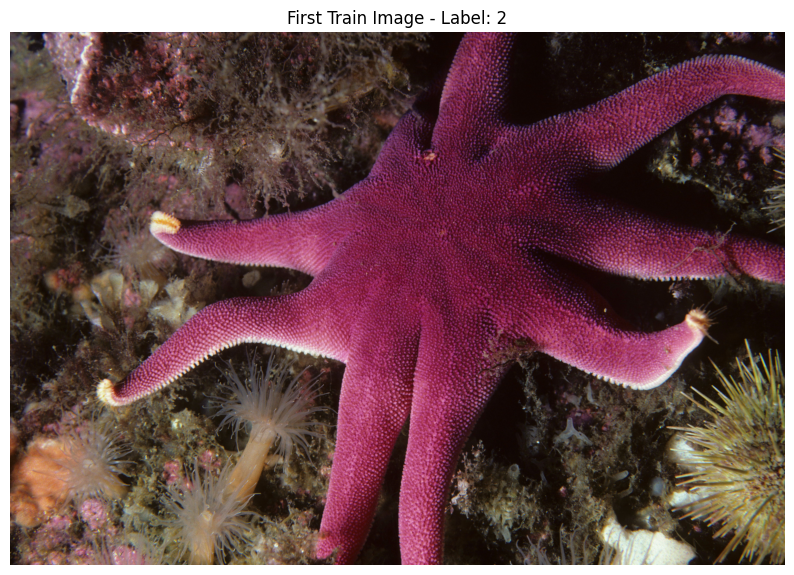

Image size: (2040, 1404)
Image mode: RGB


In [4]:
import matplotlib.pyplot as plt

# Get the first train image
first_image = ds['train'][0]['image']

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(first_image)
plt.axis('off')
plt.title(f"First Train Image - Label: {ds['train'][0]['label']}")
plt.show()

# Print image info
print(f"Image size: {first_image.size}")
print(f"Image mode: {first_image.mode}")

In [5]:
import numpy as np
from PIL import Image

def create_lr_image(hr_image, scale=2):
    """Downsample HR image to create LR version using bicubic interpolation"""
    if isinstance(hr_image, np.ndarray):
        pil_img = Image.fromarray(hr_image)
    else:
        pil_img = hr_image
    
    w, h = pil_img.size
    lr_size = (w // scale, h // scale)
    lr_img = pil_img.resize(lr_size, Image.BICUBIC)
    return np.array(lr_img)

# Split train data into train (90%) and validation (10%)
train_val_split = ds['train'].train_test_split(test_size=0.1, seed=42)
train_data = train_val_split['train']
val_data = train_val_split['test']
test_data = ds['test']

print("Processing training data...")
y_train = np.array([np.array(example['image']) for example in train_data], dtype=object)
x_train = np.array([create_lr_image(example['image']) for example in train_data], dtype=object)

print("Processing validation data...")
y_val = np.array([np.array(example['image']) for example in val_data], dtype=object)
x_val = np.array([create_lr_image(example['image']) for example in val_data], dtype=object)

print("Processing test data...")
y_test = np.array([np.array(example['image']) for example in test_data], dtype=object)
x_test = np.array([create_lr_image(example['image']) for example in test_data], dtype=object)

print("\nDataset shapes:")
print(f"x_train shape: {x_train.shape} (LR)")
print(f"y_train shape: {y_train.shape} (HR)")
print(f"x_val shape: {x_val.shape} (LR)")
print(f"y_val shape: {y_val.shape} (HR)")
print(f"x_test shape: {x_test.shape} (LR)")
print(f"y_test shape: {y_test.shape} (HR)")

print("\nSample sizes:")
print(f"Training examples: {len(x_train)}")
print(f"Validation examples: {len(x_val)}")
print(f"Test examples: {len(x_test)}")

print("\nExample image shapes:")
print(f"x_train[0] shape: {x_train[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

Processing training data...
Processing validation data...
Processing test data...

Dataset shapes:
x_train shape: (1152,) (LR)
y_train shape: (1152,) (HR)
x_val shape: (128,) (LR)
y_val shape: (128,) (HR)
x_test shape: (320,) (LR)
y_test shape: (320,) (HR)

Sample sizes:
Training examples: 1152
Validation examples: 128
Test examples: 320

Example image shapes:
x_train[0] shape: (171, 255, 3)
y_train[0] shape: (342, 510, 3)


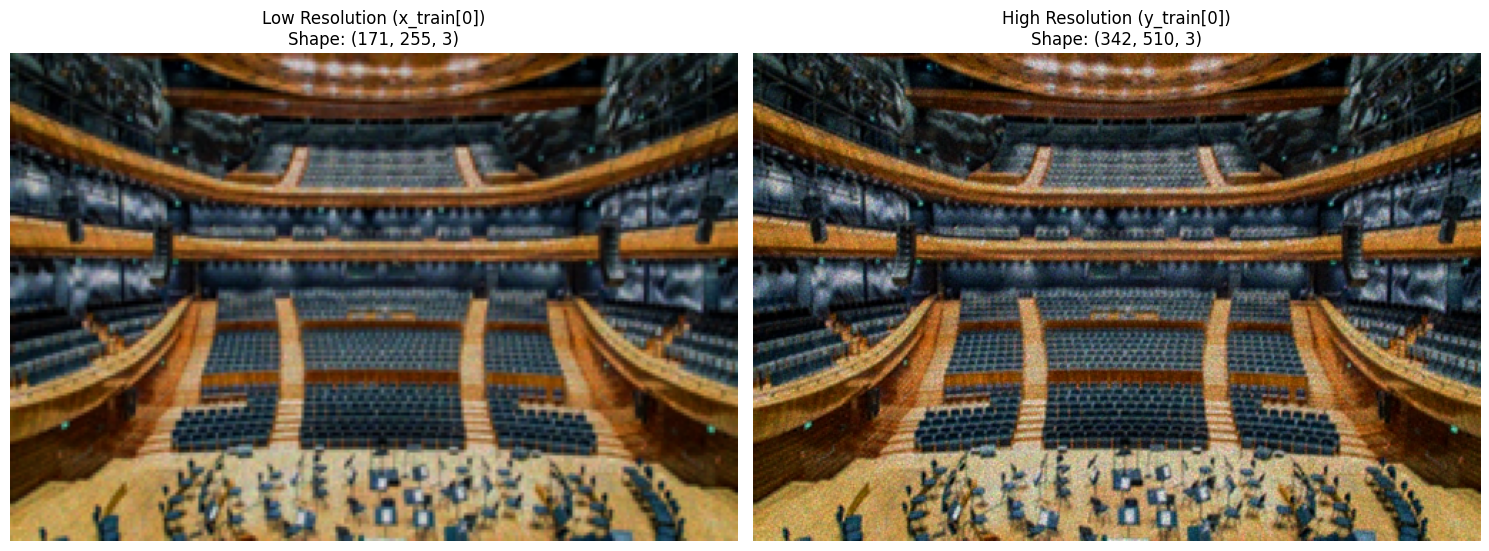

In [6]:
# Display the first training image (LR and HR side by side)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Display LR image
axes[0].imshow(x_train[0])
axes[0].set_title(f'Low Resolution (x_train[0])\nShape: {x_train[0].shape}')
axes[0].axis('off')

# Display HR image
axes[1].imshow(y_train[0])
axes[1].set_title(f'High Resolution (y_train[0])\nShape: {y_train[0].shape}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Calculate quartile statistics for image dimensions
import numpy as np

# Extract heights and widths for HR training data
hr_heights = [img.shape[0] for img in y_train]
hr_widths = [img.shape[1] for img in y_train]

# Extract heights and widths for LR training data
lr_heights = [img.shape[0] for img in x_train]
lr_widths = [img.shape[1] for img in x_train]

# Calculate quartiles
print("HIGH RESOLUTION (HR) Training Data Statistics:")
print("=" * 50)
print("\nHeights:")
print(f"  Q1 (25th percentile): {np.percentile(hr_heights, 25):.0f}")
print(f"  Median (50th percentile): {np.percentile(hr_heights, 50):.0f}")
print(f"  Q3 (75th percentile): {np.percentile(hr_heights, 75):.0f}")

print("\nWidths:")
print(f"  Q1 (25th percentile): {np.percentile(hr_widths, 25):.0f}")
print(f"  Median (50th percentile): {np.percentile(hr_widths, 50):.0f}")
print(f"  Q3 (75th percentile): {np.percentile(hr_widths, 75):.0f}")

print("\n" + "=" * 50)
print("LOW RESOLUTION (LR) Training Data Statistics:")
print("=" * 50)
print("\nHeights:")
print(f"  Q1 (25th percentile): {np.percentile(lr_heights, 25):.0f}")
print(f"  Median (50th percentile): {np.percentile(lr_heights, 50):.0f}")
print(f"  Q3 (75th percentile): {np.percentile(lr_heights, 75):.0f}")

print("\nWidths:")
print(f"  Q1 (25th percentile): {np.percentile(lr_widths, 25):.0f}")
print(f"  Median (50th percentile): {np.percentile(lr_widths, 50):.0f}")
print(f"  Q3 (75th percentile): {np.percentile(lr_widths, 75):.0f}")

print("\n" + "=" * 50)
print(f"\nTotal training images: {len(y_train)}")

HIGH RESOLUTION (HR) Training Data Statistics:

Heights:
  Q1 (25th percentile): 339
  Median (50th percentile): 510
  Q3 (75th percentile): 1356

Widths:
  Q1 (25th percentile): 510
  Median (50th percentile): 510
  Q3 (75th percentile): 2040

LOW RESOLUTION (LR) Training Data Statistics:

Heights:
  Q1 (25th percentile): 169
  Median (50th percentile): 255
  Q3 (75th percentile): 678

Widths:
  Q1 (25th percentile): 255
  Median (50th percentile): 255
  Q3 (75th percentile): 1020


Total training images: 1152


In [8]:
# Create super-resolution model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(None, None, 3)),
        layers.Conv2DTranspose(
            filters=3,
            kernel_size=4,
            strides=2,
            padding='same',
            activation='sigmoid'
        )
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, None, None, 3)  │           147 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)